# Variational auto encoders

**By Dominic Vian**

For this coursework I am going to explore the use of variational auto encoders (VAEs) and how you can use the latent space to produce new and interesting images, as seen in chaper 12 of Deep Learning with Python (DLWP), by François Chollet.


Variational Autoencoders (VAEs) are generative models that learn to approximate the distribution of high-dimensional data by encoding it into a lower-dimensional representation (latent space) and then decoding it back to the original space. They consist of two main components: an encoder network that maps the input data to the latent space, and a decoder network that maps the latent representation back to the original data. The key idea behind VAEs is to force the learned representation in the latent space to be continuous and smooth, allowing the model to generate new samples by randomly sampling from the latent space and decoding them. VAEs have been used for a wide range of tasks, including image generation, representation learning, and anomaly detection.

Autoencoders are trained on a specific dataset, and their performance may degrade on inputs that differ greatly from the training data. For instance, an autoencoder trained on images of cats may not perform well on images of cars, as it has learned to encode and decode only cat images. On the other hand, Variational Autoencoders (VAEs) can handle diverse inputs more effectively because they learn a continuous, low-dimensional representation, of the input data. The input data is mapped the latent space through parameters such as mean and standard deviation of a statistical distribution, making the VAE's representation not limited to the exact training data, but rather a broader range of data with similar properties.

**Dataset**

In DLWP, chollet uses the MNIST dataset to interpolate between different hand drawn numbers. I want to use a similar method but on images of celebrities. I am going to use the CelebA dataset, which contains 202,599 images of celebrities, each with 40 attribute annotations. The images are 218x178 pixels and are in colour. The dataset can be downloaded from [here](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Chollet uses this dataset when he is building Generative Adversarial Networks (GANs) in chapter 12 of DLWP. I am going to use the same dataset for this coursework, but I am going to use a variational autoencoder instead of a GAN as I want to explore the use of the latent space. GANs are a type of generative model that can be used to generate new images. However, the latent space they learn does not have a continuous structure, which means that it is not possible to interpolate between different data points. This is why I am going to use a variational autoencoder instead of a GAN.


**Workflow**

The workflow for this coursework is as follows:
1. Load the dataset
2. Preprocess the data
3. Build the encoder
4. Build the decoder 
5. Build the model architecture 
6. Train the variational autoencoder
7. Interpolate between different latent space vectors
8. Generate new images


# Prerequisites

In [2]:

import json
import zipfile
import os
import psutil
from IPython import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.transform as sktrans
import time
import glob
import imageio
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import Model, Sequential, metrics, optimizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D,\
                                    MaxPooling2D, UpSampling2D, GlobalAveragePooling2D,\
                                    Layer, Lambda,Flatten, Reshape, Conv2DTranspose,\
                                    Activation, LeakyReLU, Dropout, InputLayer
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

# First experiments 

## Downloading and processing the data

The code below downloads the CelebA dataset and processes it by cropping the images based on landmarks. It then resizes the images to (128,128), and normalizes them to (0,1).
We then divide the data into three sets: train_ds, val_ds and test_ds, and a further two more sets: smiling_ds and not_smiling_ds based off of the attribute annotations. The steps_per_epoch and validation_steps are calculated based on the size of each dataset and the desired batch size.

In [34]:
batch_size = 64

def crop_resize_normalize(item):
    
    img = item['image']
    landmarks = item['landmarks']
    
    # Get lefteye and righteye coordinates
    lx, ly = landmarks['lefteye_x'], landmarks['lefteye_y']
    rx, ry = landmarks['righteye_x'], landmarks['righteye_y']
    
    # lefteye will be in (0.3, 0.3) coordinates on cropped image,
    # so we will calculate lefteye to border based on lefteye position
    le_to_border = tf.cast(tf.cast(rx - lx, tf.float32) * 0.75, tf.int64)
    
    # Calculate top-left position of face
    offset_height = ly - le_to_border
    offset_width = lx - le_to_border
    
    # Calculate height and width of bounding box
    target_height = tf.cast(tf.cast(le_to_border, tf.float32) * 10 / 3, tf.int64)
    target_width = target_height
    

    width, height = img.shape[-3: -1]
    target_height = tf.cond(offset_height + target_height > height,
                            lambda: tf.subtract(tf.cast(height, tf.int64),
                                                offset_height),
                            lambda: target_height)
    target_width = tf.cond(offset_width + target_width > width,
                            lambda: tf.subtract(tf.cast(width, tf.int64),
                                                offset_width),
                            lambda: target_width)
    
    # Crop image
    offset_height = tf.cast(offset_height, tf.int32)
    offset_width = tf.cast(offset_width, tf.int32)
    target_height = tf.cast(target_height, tf.int32)
    target_width = tf.cast(target_width, tf.int32)
    cropped = tf.image.crop_to_bounding_box(img, offset_height, offset_width,
                                            target_height, target_width)
    
    # Normalize and resize image
    resized = tf.image.resize(tf.cast(cropped, tf.float32) / 255.0, [128, 128])
    item['image'] = resized
    return item


def preprocess(image):
    # Returns image, image because when training, vae expects same input image as output
    image = image['image']
    return image

def preprocess_test(image):
    return image['image']

def smiling_preprocess(batch):
    imgs = batch['image']
    smiling = batch['attributes']['Smiling']
    return imgs[smiling]

def not_smiling_preprocess(batch):
    imgs = batch['image']
    smiling = batch['attributes']['Smiling']
    return imgs[~smiling]


# Download data
data, info = tfds.load("celeb_a", with_info=True)
train_data, val_data, test_data = data['train'], data['validation'], data['test']

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['validation'].num_examples // batch_size

# Define train, validation and test datasets
train_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
val_ds = val_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
test_ds = test_data.map(crop_resize_normalize).map(preprocess_test).repeat().batch(batch_size).prefetch(1)
# Define smiling and not-smiling datasets
attr_data = tfds.load("celeb_a", split=tfds.Split.ALL)
smiling_ds = attr_data.map(crop_resize_normalize).batch(batch_size).map(smiling_preprocess)
not_smiling_ds = attr_data.map(crop_resize_normalize).batch(batch_size).map(not_smiling_preprocess)
     

Some example images from the dataset:

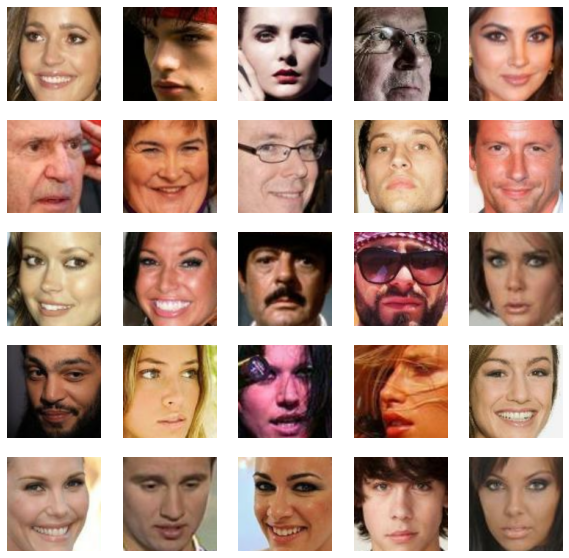

In [35]:
images = next(iter(test_ds))

fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(images[i])
    ax.axis("off")
plt.show()

## Defining the encoder and decoder networks

Variational autoencoders consist of two main components an encoder network and a decoder network. The Encoder network is responsible for encoding the input data into a lower-dimensional, latent space representation. The decoder network is responsible for decoding the latent space representation back into the original input data. The latent space representation is a continuous space, which means that it is possible to interpolate between different data points. This is useful for generating new images, as we can interpolate between different latent space vectors.

The encoder_network function creates an encoder model for image compression and representation learning. It takes an image (input_shape) and a latent dimension (latent_dim) as inputs. The function defines a custom sampling function that calculates the sampled latent code from the mean and log-variance of the code. The sampling stage of a Variational Autoencoder (VAE) is a crucial component that maps the learned representations to a continuous latent space. It involves generating random samples from a normal distribution and combining them with the mean and variance outputs of the encoder network. This results in a set of latent codes that can be fed into the decoder network to generate new synthetic data. The purpose of the sampling stage is to add randomness to the learned representations and enable the VAE to generate diverse outputs.

The decoder_network function creates a decoder model for image reconstruction. It takes the latent dimension (latent_dim) as input. 

In [45]:
def encoder_network(input_shape, latent_dim=100):
    def sampling(args):
        z_mean, z_log_var = args
        epsilon_mean = 0
        epsilon_std = 1.0
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=epsilon_mean, stddev=epsilon_std)
        sampled_z = z_mean + K.exp(z_log_var / 2) * epsilon
        return sampled_z
    
    input_img = Input(shape=input_shape)
    x = Conv2D(32, 4, strides=(2, 2))(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = GlobalAveragePooling2D()(x)

    z_mean = Dense(latent_dim, name='mean')(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling)([z_mean, z_log_var])

    encoder = Model(input_img, [z_mean, z_log_var,z])
    return encoder

def decoder_network(latent_dim=100):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(4096)(decoder_input)
    x = Reshape((4, 4, 256))(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(128, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(64, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(32, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')(x)

    decoder = Model(decoder_input, x)
    return decoder


The encoder architecture is composed of several 2D convolutional layers with batch normalization and leaky ReLU activation, followed by a global average pooling layer and two dense layers for the mean and log-variance of the code. The output of the encoder is the mean, log-variance, and the sampled latent code of the input image.


The decoder architecture is composed of several 2D transposed convolutional layers with batch normalization and leaky ReLU activation, followed by a dense layer and reshaping to the original image size. The decoder takes the latent code as input and outputs the reconstructed image.

In [46]:
encoder = encoder_network(input_shape=(128, 128,3))
encoder.summary()

decoder = decoder_network()
decoder.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_135 (Conv2D)            (None, 63, 63, 32)   1568        ['input_31[0][0]']               
                                                                                                  
 batch_normalization_123 (Batch  (None, 63, 63, 32)  128         ['conv2d_135[0][0]']             
 Normalization)                                                                                   
                                                                                           

## Preprocessor

The function below creates a preprocessor model with a single input layer and outout layer. The input shape is (128,128,3), the same as the images from the dataset. The input tensor is scaled using the rescaling function and a preprocessed tensor is returned.

In [21]:
def create_preprocessor():
    
    inputs = Input(shape=(128, 128, 3))
    preprocessed = tf.keras.layers.Rescaling(1./255)(inputs)
    preprocessor = Model(inputs, preprocessed, name="preprocessor")

    return preprocessor

## Build model class

Here we define out model and its loss functions. The model takes a preprocessor, encoder, decoder, alpha, beta as arguments during its initialization. In the forward pass, the input (data) is first preprocessed, then passed through the encoder to obtain the mean, log_sigma, and a sample from the latent space. The decoder takes the sample from the latent space and reconstructs an output.

The compute_loss method calculates the reconstruction loss and KL-divergence loss, and combines them with the weighting factors alpha and beta to get the total loss. Reconstruction loss measures the difference between the original data and its reconstructed form produced by the VAE. This loss function helps the model to learn how to reconstruct the input data. In this case the reconstruction loss is the pixel-by-pixel mean squared error between the input image and the generated one. KL-divergence loss measures the difference between the distribution of latent variables (encoded from the input data) and the prior distribution. This loss function helps the model to ensure that the latent variables follow a desired distribution. KL-divergence is used as a regularization term to prevent the model from overfitting to the data

The train_step method performs a forward pass to obtain the loss, then computes gradients and updates the model's parameters. The method also updates the trackers for loss, reconstruction loss, and KL-divergence loss.

The call method performs a forward pass and calculates the loss similarly to the train_step method, but it doesn't update the parameters. The method updates the trackers for loss, reconstruction loss, and KL-divergence loss.

In [25]:
class Simple_VAE(Model):

    def __init__(self, preprocessor, encoder, decoder, alpha,  beta, **kwargs):
        super(Simple_VAE, self).__init__(**kwargs)
        self.preprocessor = preprocessor
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = metrics.Mean(name="loss")
        self.loss_wo_weight_tracker = metrics.Mean(name="loss_wo_weight")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        self.alpha = alpha
        self.beta = beta
    

    @property
    def metrics(self):
        # list the metrics objects so the the reset_states() can be called automatically 
        # at the start of each epoch or at the start of an evaluation

        return [self.loss_tracker, 
                self.loss_wo_weight_tracker, 
                self.reconstruction_loss_tracker, 
                self.kl_loss_tracker]
    

    def forward(self, data):
        # The forward pass of the model
        preprocessed = self.preprocessor(data)
        z_mean, z_log_sigma, z = self.encoder(preprocessed)
        reconstruction = self.decoder(z)
        return  z_mean, z_log_sigma, reconstruction
    

    def compute_loss(self, data, z_mean, z_log_sigma, reconstruction):
        # compute the loss function
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        loss_wo_weight = reconstruction_loss + kl_loss
        loss = self.alpha * reconstruction_loss + self.beta * kl_loss
        return reconstruction_loss, kl_loss, loss, loss_wo_weight
    

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # the forward pass
            z_mean, z_log_sigma, reconstruction = self.forward(data)
            # compute the loss
            reconstruction_loss, kl_loss, loss, loss_wo_weight = self.compute_loss(data, z_mean, z_log_sigma, reconstruction)
            
        # compute the gradients
        grads = tape.gradient(loss, self.trainable_variables)

        # update the weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # update the metrics (losses in this case)
        self.loss_tracker.update_state(loss)
        self.loss_wo_weight_tracker.update_state(loss_wo_weight)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result(),
                "loss_wo_weight": self.loss_wo_weight_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}


    def call(self, data):
        # the forward pass
        z_mean, z_log_sigma, reconstruction = self.forward(data)
        
        # compute the loss
        reconstruction_loss, kl_loss, loss, loss_wo_weight = self.compute_loss(data, z_mean, z_log_sigma, reconstruction)
        # update the metrics (losses in this case)
        self.loss_tracker.update_state(loss)
        self.loss_wo_weight_tracker.update_state(loss_wo_weight)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result(),
                "loss_wo_weight": self.loss_wo_weight_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                "reconstruction": reconstruction}


## Training the model

Here we compile the model, define the callback functions and optimizer and then train the model. Alpha is the weight for the reconstruction loss and beta the weight for the KL-divergence loss. I used Adam optimizer for this as it is easy to impliment and computationally efficient. I used a learning rate of 0.0015 and I also adjusted the beta_1 and beta_2 parameters, thus adjusting the decay rates of the optimizer.

In [26]:
alpha = 1.8
beta = 10
lr = 0.0015

input_shape = (128,128,3)
latent_dim = 100

spreprocessor = create_preprocessor()
sencoder = encoder_network(input_shape, latent_dim)
sdecoder = decoder_network(latent_dim)

svae = Simple_VAE(spreprocessor,sencoder, sdecoder, alpha, beta)
svae.compile(optimizer=optimizers.Adam(learning_rate=lr, beta_1 = 0.9, beta_2 = 0.999))

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss_wo_weight', factor=0.2, patience=2, verbose=1, mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath= './svae/', monitor='val_loss_wo_weight', save_best_only=True, verbose=1)]

history_svae = svae.fit(x=train_ds,steps_per_epoch=steps_per_epoch, epochs=3, validation_data=val_ds,validation_steps=validation_steps, batch_size=batch_size, callbacks=callbacks)

Epoch 1/3
2543/2543 [==============================] - ETA: 0s - loss: 0.0816 - loss_wo_weight: 0.0446 - reconstruction_loss: 0.0444 - kl_loss: 1.6227e-04

ValueError: ignored

After many hours of vigorously attempting to debug my code and train my model I decided (due to lack of time) my time was better spent experimenting on a different dataset where I could get a model to train, so that I could examine the results of this type of neural network. I had hoped, after training the above simple VAE, to build a model that used perceptual loss by utilising the pretrained VGG19 network, as described in the writing 'Deep Feature Consistent Variational Autoencoder' that can be found here: https://arxiv.org/pdf/1610.00291.pdf. The concept being that instead of using the pixel-by-pixel mean squared error between the input image and the generated one, I could send it to the VGG19 network and measure the difference between the hidden layer representations. The VGG19 model is a deep convolutional neural network that has been trained on the ImageNet dataset. This model can classify images into 1000 different object categories and its use of 3x3 filters makes it a very powerful tool to apply to many image related problems. Unfortunately, I was unable to do this due to my previous model not training as I was not able to achieve this. However, I would like to complete this in the future. 

# Second experimants

For the next stage in my research, I decided to use the MNIST dataset, which is a dataset of 70,000 greyscale handwritten digits. The dataset is available from the tensorflow datasets library so is easily accessible. This dataset is also use in Deep Learning with Python by Francois Chollet, so I was able to look at his code as a starting point. My goal at this stage was to first build a model that could train on this dataset, then adjust the architetcure and hyperparameters to see if I could improve the results.

The template for the code below is taken from the tensorflow website: https://www.tensorflow.org/tutorials/generative/cvae. I made changes to the model arcehitecture and hyperparameters to see what results I could achieve.

## Processing data

Loading the data:

In [50]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

An example from the mnist dataset

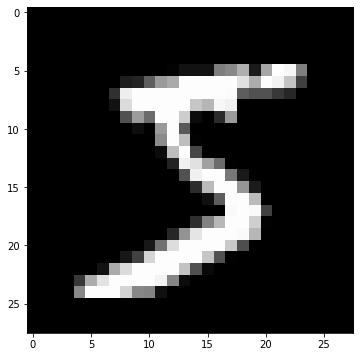

In [52]:
# Select an image
display_image = train_images[0]

# Display the selected image
plt.imshow(display_image, cmap='gray')
plt.show()

The function below preprocesses the data by first reshaping it to (images.shape[0], 28,28,1), where the first dimension is the number of images, and the last dimension is the number of channels, which is set to one as the images are in greyscale. The data is then normalized by dividing it by 255.0. Finally, the function applies a thresholding operation to the images, converting pixel values greater than 0.5 to 1.0 and values less than 0.5 to 0.0. The processed images are returned as float32 data type.

In [53]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28,28,1))/255. 
  return np.where(images>.5, 1.0,0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

Here we split the data into its seperate partitions and define the batch size.

In [54]:
train_size = 60000
batch_size = 32
test_size = 10000

we then convert the train_images tensor into a dataset of tensor slices. The dataset is then shuffled using the shuffle method, which randomly shuffles the elements of the dataset, and then batched using the batch method, which groups the elements of the dataset into batches of size batch_size.

In [55]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).
                 shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).
                 shuffle(test_size).batch(batch_size))

## Building a network

Much like before we build our network by defining the encoder and decoder networks and our sampling function. However, we have a few different function such as the encode, reparameterize and decode functions. Encode computes the mean and log variance of the input image in the latent space. Reparameterize computes a sample from the Gaussian distribution in the latent space. and decode generates a reconstruction of the input image. Gaussian distribution, also known as a normal distribution, is a continuous probability distribution that is symmetrical about its mean and is described by its mean and standard deviation.

In [56]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32,4, strides=(2,2), padding='same', activation=None),
            tf.keras.layers.BatchNormalization(axis=-1),
            tf.keras.layers.LeakyReLU(alpha=0.3),

            # 64x4x4 convolutional layer with stride 2 then Batch normalisation and then leaky relu 
            tf.keras.layers.Conv2D(64,(4,4), strides=2, padding='same', activation=None),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.3),
     
    
            # 128x4x4 convolutional layer with stride 2 then Batch normalisation and then leaky relu 
            tf.keras.layers.Conv2D(128,(4,4), strides=2, padding='same', activation=None),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.3),

            # 256x4x4 convolutional layer with stride 2 then Batch normalisation and then leaky relu 
            tf.keras.layers.Conv2D(256,(4,4), strides=2, padding='same', activation=None),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.3),

            # flattening layer
            tf.keras.layers.Flatten(data_format='channels_last'),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

We can see out models architecture below:

In [57]:
cvae = CVAE(latent_dim=100)
cvae.encoder.summary()
cvae.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_145 (Conv2D)         (None, 14, 14, 32)        544       
                                                                 
 batch_normalization_132 (Ba  (None, 14, 14, 32)       128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_132 (LeakyReLU)  (None, 14, 14, 32)       0         
                                                                 
 conv2d_146 (Conv2D)         (None, 7, 7, 64)          32832     
                                                                 
 batch_normalization_133 (Ba  (None, 7, 7, 64)         256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_133 (LeakyReLU)  (None, 7, 7, 64)         0

## Define the loss and optimizer 

The log_normal_pdf function computes the logarithm of normal distribution probability density function. The logarithm of the normal distribution density function is used to calculate the loss because the VAE involves computing the probability of observed data given the latent code, which involves multiplying the density of each dimension of the latent code. The logarithm of the density function is used to prevent numerical instability that can arise when the densities are very small. Using the logarithm allows for the computation of the product of the densities as a sum of the logarithms, which is more stable computationally.

The compute_loss function calculates the loss for the model based on the input data x. It does this by encoding the input into a mean and log-variance, using the reparameterize function to sample a latent variable z from this distribution, then decoding z to a reconstruction x_logit of the input. The cross-entropy between the reconstructed image x_logit and the original input x is used as a measure of reconstruction error. The log-probability of the latent variable z given the input x (logqz_x), log-probability of the latent variable z prior to the input (logpz), and the log-probability of the input given the latent variable z (logpx_z) are used to form the total loss. The final loss is obtained by subtracting the mean of the logpx_z, logpz and logqz_x. 

The train_step function uses tf.GradientTape to calculate the gradients of the loss with respect to the model's trainable variables, and then applies these gradients to the optimizer.

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training 

In [60]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

A function to plot predictions:

In [61]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [62]:

assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

The training:

Epoch: 10, Test set ELBO: -142.24151611328125, time elapse for current epoch: 7.287041664123535


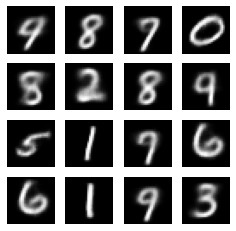

In [63]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

## Displaying images

Here we can see the output of this model. We can see that the model is able to generate images that look like the original images, however, the images are not as clear as the original images. This is due to the fact that the model is not able to learn the distribution of the data well enough to generate images that are as clear as the original images. However, the model is able to generate images that look like the original images, which is a good sign.

In [64]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

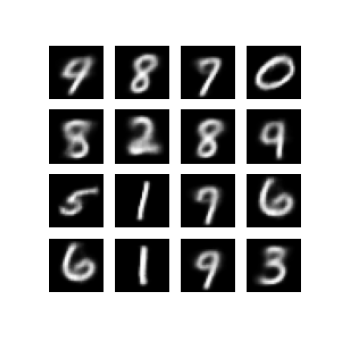

In [65]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

## Animation

An animation showing the saved images from each epoch and how they change over the training process:

In [66]:
anim_file_VAE = 'cvae.gif'

with imageio.get_writer(anim_file_VAE, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
!pip3 install git+https://github.com/tensorflow/docs


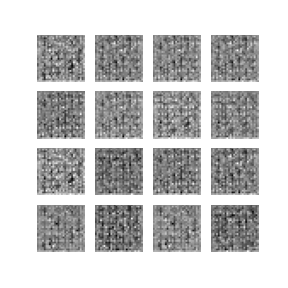

In [69]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_VAE)

## 2d manifold of digits from the latent space 

Below is a a grid of samples from the latent space. We can see the continuous distrubution of the different digit classes as the digits morph into one another 

In [70]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

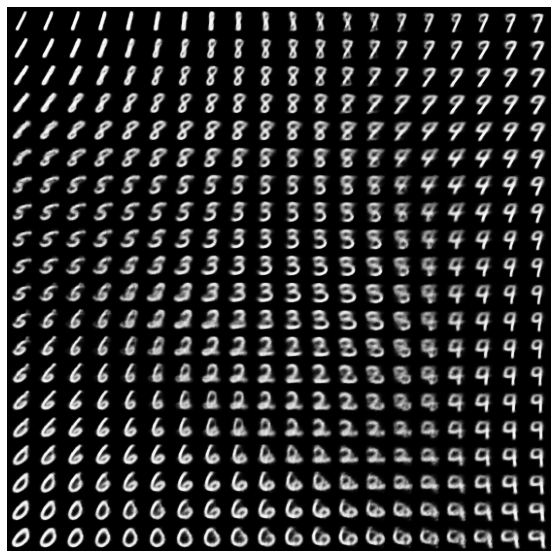

In [ ]:
plot_latent_images(model, 20)

# Third experiments

## Gans

I decided I wanted compare the output of my VAE model to the output of a GAN model. Both VAEs and GANs are generative image processing models, however, they are very different. VAEs are a type of autoencoder that learns a latent representation of the data, and then uses this representation to generate new data. GANs are a type of adversarial network that learns to generate new data by competing with a discriminator network. 

A Generative Adversarial Network (GAN) is a type of deep learning architecture used for generative modeling. It consists of two parts: a generator network and a discriminator network. The generator network generates new data samples, while the discriminator network evaluates the generated samples and determines whether they are real or fake.

The two networks are trained together in an adversarial process, where the generator tries to produce samples that the discriminator can't distinguish from real samples, and the discriminator tries to correctly identify which samples are real and which are generated. The training process continues until the generator produces samples that are realistic enough to fool the discriminator.

Once trained, the generator can be used to generate new samples by sampling from the learned latent space and transforming the samples through the generator network. GANs have been used in various applications, such as image synthesis, style transfer, and data augmentation. I wanted to see how the output of a GAN compared to the output of a VAE.

The template for the code below was taken from the tensorflow website: https://www.tensorflow.org/tutorials/generative/dcgan. I made changes to the model arcehitecture and hyperparameters to see what results I could achieve.

## Load and prepare dataset

In [71]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

This code preprocesses the training data by first transforming it into a tensor with shape (num_samples, 28, 28, 1). The pixel values in the training images are then normalized to the range [-1, 1] by dividing each pixel value by 127.5 and subtracting 1. This normalization step is useful for training deep learning models as it helps to improve the stability and convergence of the optimization process. Finally, the normalized training data is shuffled and batch into training examples of size batch_size using the tf.data.Dataset API. The buffer_size argument to shuffle specifies the buffer size used to randomize the data. The resulting train_dataset is a tensorflow dataset that can be used to efficiently iterate through the training data in mini-batches during the training process.

In [72]:
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5 #Normalize the images to [-1,1]

buffer_size = 60000
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

## Creating the models

### The generator

The generator is responsible for generating new data samples that are similar to the training data. The generator takes as input a random noise vector and transforms it into a synthetic sample that is intended to be similar to the real training data. The generator is trained through an adversarial process, where it tries to generate samples that are realistic enough to fool a discriminator network into thinking they are real. 

This generator network takes as input a random noise vector of shape (100,) and returns a generated image of shape (28, 28, 1).

The generator is implemented as a sequential model, where the different layers are added one after the other. The first layer is a dense layer with 7 * 7 * 256 neurons and a batch normalization layer to normalize the activations. The LeakyReLU activation function is used to allow for small negative values, which helps stabilize the training process.

The model then reshapes the output of the dense layer into a tensor with shape (7, 7, 256). The next three layers are transposed convolutional layers with increasing number of filters. These layers increase the spatial dimensions of the output and generate more detailed features in the generated images. The batch normalization and LeakyReLU activation functions are used after each transposed convolutional layer.

Finally, a transposed convolutional layer with one filter is used to generate the final output image with shape (28, 28, 1). The activation function used in this layer is tanh, which maps the output to the range [-1, 1], corresponding to the normalization applied to the training data.

I used strides=(2, 2) for all the transposed convolutional layers, this increases the resolutiuon of the output images, allowing for greater variety in the generated images.
The 'same' padding, as opposed to 'valid', allows the output images to have the same spatial dimensions as the input layer, and therefore maintains the consistency between inputs and outputs.

In [77]:

def make_generator():
  model = tf.keras.Sequential()
  model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  
  model.add(Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model


Here we generate an untrained images from the generator and we can see that it is just creating random noise, as it has not seen any of the data yet.

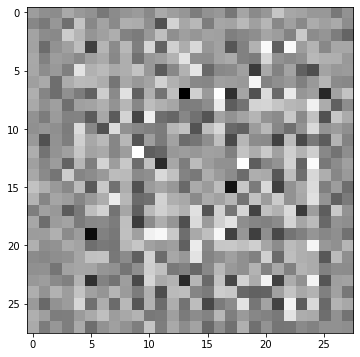

In [78]:
generator = make_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The discriminator

The purpose of the discriminator in a GAN is to identify whether the input image is real or fake. It does this by comparing the input image to a set of real images and determining whether the input image is similar enough to be considered real or whether it was generated by the generator and therefore considered fake. The discriminator's job is to learn a decision boundary between real and fake images, so that it can correctly identify images as real or fake. The generator and discriminator are trained together in a game-like manner, where the generator tries to produce images that the discriminator will identify as real, and the discriminator tries to correctly identify the images as real or fake.


The discriminator takes an image as input and outputs a scalar between 0 and 1, with 0 indicating that the input is a generated sample and 1 indicating that the input is a real sample. The discriminator is trained to maximize the probability of correctly classifying real samples as real and generated samples as generated.

A special trick mentioned in DLWP was to only use one dropout layer for the discriminator just before the final dense layer. 

In [83]:

def make_discriminator():
  model = tf.keras.Sequential()
  model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.3)) #special trick
  model.add(Dense(1))

  return model

Use untrained dsicriminator to classify if the generated images are real of fake. Positive values for real, and negative for fake

In [84]:
discriminator = make_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00295063]], shape=(1, 1), dtype=float32)


## Define loss and optimizers

The function below defines the loss function and optimizers for the networks. The cross_entropy function is instantiated as a binary cross-entropy loss with from_logits=True because the binary cross-entropy loss function is the raw output of the discriminator network, which is not yet squashed into a probability distribution over the two classes (real or fake). The sigmoid activation function will be applied to the output later in the network to obtain the final probability estimates.
Setting from_logits=True in the loss function ensures that the loss is calculated from these raw outputs, rather than from the outputs after the activation function is applied.
The discriminator_loss function calculates the total loss for the discriminator network by adding the binary cross-entropy loss between the real images and ones and the fake images and zeros. The generator_loss function calculates the generator loss by taking the binary cross-entropy loss between the generated fake images and ones.
Two optimizers, generator_optimizer and discriminator_optimizer, are defined as the Adam optimizer with a learning rate of 0.0002 and beta1 parameter of 0.5.

In [86]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


# discriminator loss
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss


# Generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Save checkpoints

This code sets up a checkpoint to save and restore the training progress. This allows you to save and restore the optimizer and model states during training, so you can pick up training where you left off if there is a need to interrupt the training process.

In [87]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator, 
                                 discriminator=discriminator)

## Define the train loop

Here we are defining the train loop. The function takes a batch of images as input and trains the generator and discriminator models for one step.
The generator is fed random noise, and the generator and discriminator outputs are computed using the real_output and fake_output variables. The generator and discriminator losses are then calculated using the generator_loss and discriminator_loss functions defined earlier.
The gradients of the loss with respect to the trainable variables of both the generator and discriminator are computed using tf.GradientTape and applied to the optimizers using the apply_gradients method.
The number of epochs to train is set to 50 and the size of the random noise vector is set to 100. The num_examples_to_generate specifies the number of examples to generate during testing. A random noise seed is generated with seed = tf.random.normal([num_examples_to_generate, noise_dim]).

In [88]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images,training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

This code trains the GAN by iterating over the specified number of epochs and the training data in dataset.
In each epoch, the function goes through the entire dataset with a for loop and calls the train_step function on each batch of images in the dataset.
Every 15 epochs, the current state of the model is saved using the checkpoint object created earlier. At the end of each epoch, the function calls generate_and_save_images to generate and save images using the current state of the generator model. The function also outputs the time it took to complete one epoch.

In [89]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()


    # produce images as it trains
    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch+1,seed)


    # save model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'. format(epoch+1, time.time()- start))

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


### Generate and save images

In [90]:
def generate_and_save_images(model,epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('images_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training

Call the train function.

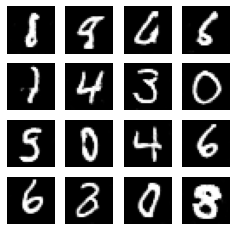

In [91]:
train(train_dataset, epochs)

This line of code restores the latest checkpoint from the checkpoint_dir directory and assigns it to the checkpoint variable. The tf.train.latest_checkpoint function returns the path of the latest checkpoint file in the directory, which can be used to restore the state of the model and its optimizers. This allows you to continue training from where you left off, or to use the trained model for inference.

In [92]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF

In [93]:
anim_file_GAN = 'dcgan.gif'


with imageio.get_writer(anim_file_GAN, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


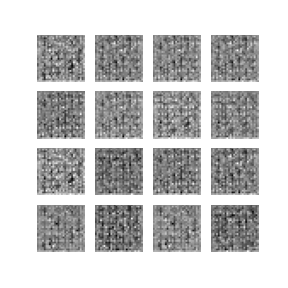

In [94]:
embed.embed_file(anim_file_GAN)

We can see that the images generated from the GAN are of higher quality than the images generated from the VAE. The images generated by the GAN are more detailed and have a greater variety of shapes. The images generated by the VAE are blurry and have a limited variety of shapes and colors. The images generated by the GAN are more realistic and resemble the training data more closely as the MNIST data consists of hand drawn numbers. The data produced by our network clearly look hand drawn. We can also clearly see the improvement in the quality of the generated images as the training progresses from the animation above.

## Conclusion

In conclusion, Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs) are two popular generative models used to synthesize new data similar to a given training dataset. Both have been widely researched and used in a variety of applications, ranging from computer vision to natural language processing. When trained on the MNIST dataset, both GANs and VAEs produce new images of handwritten digits that are similar to those in the training data. However, the outputs of these two models can differ significantly in terms of quality, diversity, and stability, with GANs often producing more high-quality and diverse images, while VAEs tend to be more stable and smooth. Ultimately, the choice of which model to use depends on the specific requirements and goals of the task at hand, and both GANs and VAEs continue to be active areas of research with new developments and improvements being made all the time. 

Although my initial experiments could not be completed I was able to learn alot about the implimentations of both GANs and VAEs and I hope to be able to complete this project in the future. I would also like to try and impliment a GAN on a different dataset, maybe the CelebA dataset, and see how the results compare to the MNIST dataset. I would also like to try and impliment a VAE on a different dataset and see how the results compare. The field of Generative Models is fascinating and I am eager to continue learning and experimenting with it in the future.